# LIGHTGBM - REGRESSION - TEST

In [1]:
import numpy as np
from sklearn import datasets
import lightgbm as lgb
import pandas as pd
from datetime import datetime
from time import time
from sklearn.metrics import balanced_accuracy_score

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.utils.multiclass import unique_labels

import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

from sklearn.metrics import roc_curve, auc

from functools import partial
import scipy as sp

from sklearn.base import BaseEstimator, TransformerMixin

### GLOBAL VARIABLES

In [3]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 100
CV = 3
SCORE = 'rmse'
handlingnull = False
NJOBS = 2
USEGPU = False
NCLASS = 0

### FUNCTIONS

In [4]:
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True

In [5]:

class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [6]:
def sklearn_qwk(y_true, y_pred) -> np.float64:
    """
    Function for measuring Quadratic Weighted Kappa with scikit-learn
    
    :param y_true: The ground truth labels
    :param y_pred: The predicted labels
    
    :return The Quadratic Weighted Kappa Score (QWK)
    """
    return metrics.cohen_kappa_score(y_true, y_pred, weights="quadratic")

In [7]:
def plot_importance(booster, figsize=(10,5), feature_names=None, **kwargs): 
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    if feature_names:
        mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
        mapped = {mapper[k]: v for k, v in booster.get_fscore().items()}
        return xgb.plot_importance(mapped, ax=ax, **kwargs)
    else:
        return xgb.plot_importance(booster=booster, ax=ax, **kwargs)
    pass

In [8]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[c] for c in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### LOAD DATASET

In [10]:
train_features = pd.read_pickle(DATAPATH+'X_train.pkl')

In [11]:
train_labels = pd.read_pickle(DATAPATH+'y_train.pkl')

In [12]:
test_features = pd.read_pickle(DATAPATH+'X_test.pkl')

In [13]:
test_labels = pd.read_pickle(DATAPATH+'y_test.pkl')

In [14]:
train_features.shape

(12383, 89)

In [15]:
test_features.shape

(5307, 89)

In [16]:
### create a DMatrix and handling Null values
lgb_train = lgb.Dataset(data=train_features, label=train_labels)

In [17]:
lgb_valid = lgb.Dataset(data=test_features, label=test_labels)

In [18]:
lgb_test = lgb.Dataset(test_features)

### TRAIN MODEL

#### Set hyperparameters

In [19]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
boosting = 'gbdt'


# Learning Task Parameters
# This defines the loss function to be minimized. See documentation
# -  options: regression, regression_l1, huber, fair, poisson, quantile, 
# mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda,
# lambdarank, aliases: objective_type, app, application
objective  = 'regression'


# The metric to be used for validation data.
# - rmse, root square loss, aliases: root_mean_squared_error, l2_root
# - quantile, Quantile regression
# - mape, MAPE loss, aliases: mean_absolute_percentage_error
# - huber, Huber loss
# - fair, Fair loss
# - poisson, negative log-likelihood for Poisson regression
# - gamma, negative log-likelihood for Gamma regression
# - gamma_deviance, residual deviance for Gamma regression
# - tweedie, negative log-likelihood for Tweedie regression
# - ndcg, NDCG, aliases: lambdarank
# - map, MAP, aliases: mean_average_precision
# - auc, AUC
# - binary_logloss, log loss, aliases: binary
metric = 'rmse'

eval_metric = eval_qwk_lgb_regr

In [20]:
model = lgb.LGBMRegressor()

In [21]:
model_param = model.get_params()

In [22]:
model_param

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [23]:
model_param['seed'] = SEED
model_param['boosting'] = boosting
model_param['objective'] = objective
#model_param['n_estimator'] = 313
#model_param['scale_pos_weight'] = scale_pos_weight
model_param['nthread'] = 8

In [24]:
early_stopping_rounds = 50

In [25]:
cvresult = lgb.cv(model_param, lgb_train, num_boost_round = 1000, nfold = CV, metrics = metric, early_stopping_rounds = early_stopping_rounds, seed = SEED)

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [26]:
cvresult = pd.DataFrame(cvresult)

In [27]:
n_estimators = cvresult.shape[0]

In [30]:
model_param['n_estimators'] = n_estimators

In [31]:
model = lgb.train(model_param, lgb_train, lgb_train,valid_sets=lgb_valid, 
                        early_stopping_rounds=early_stopping_rounds)

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	valid_0's l2: 1.48419
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 1.40603
[3]	valid_0's l2: 1.3426
[4]	valid_0's l2: 1.28885
[5]	valid_0's l2: 1.24579
[6]	valid_0's l2: 1.21108
[7]	valid_0's l2: 1.18182
[8]	valid_0's l2: 1.15822
[9]	valid_0's l2: 1.13767
[10]	valid_0's l2: 1.12222
[11]	valid_0's l2: 1.10936
[12]	valid_0's l2: 1.09807
[13]	valid_0's l2: 1.08944
[14]	valid_0's l2: 1.08154
[15]	valid_0's l2: 1.07506
[16]	valid_0's l2: 1.06841
[17]	valid_0's l2: 1.06334
[18]	valid_0's l2: 1.05757
[19]	valid_0's l2: 1.05323
[20]	valid_0's l2: 1.04837
[21]	valid_0's l2: 1.04427
[22]	valid_0's l2: 1.04089
[23]	valid_0's l2: 1.03728
[24]	valid_0's l2: 1.03545
[25]	valid_0's l2: 1.03407
[26]	valid_0's l2: 1.03173
[27]	valid_0's l2: 1.02945
[28]	valid_0's l2: 1.02605
[29]	valid_0's l2: 1.02337
[30]	valid_0's l2: 1.0213
[31]	valid_0's l2: 1.0201
[32]	valid_0's l2: 1.01803
[33]	valid_0's l2: 1.01711
[34]	valid_0's l2: 1.01604
[35]	valid_0's l2: 1.01638
[36]	

#### Optimized Rounder

In [32]:
y_valid_pred = model.predict(train_features)

In [33]:
y_pred = model.predict(test_features)

In [34]:
optR = OptimizedRounder()
optR.fit(y_valid_pred, train_labels)
coefficients = optR.coefficients()


In [35]:
valid_predictions = optR.predict(y_valid_pred, coefficients)



In [36]:
np.unique(valid_predictions)

array([0, 1, 2, 3])

In [37]:
coefficients

array([1.0812128 , 1.62865866, 2.18982003])

In [38]:
test_predictions = optR.predict(y_pred, coefficients)

In [39]:
print(SCORE,' : ', mean_squared_error(test_labels,y_pred))

rmse  :  1.0001984056953472


In [40]:
print('QWK : ', sklearn_qwk(test_labels, test_predictions))

QWK :  0.5819816307370336


Confusion matrix, without normalization
[[ 661  267  204  137]
 [ 143  191  222  167]
 [  54  114  181  312]
 [ 107  226  575 1746]]


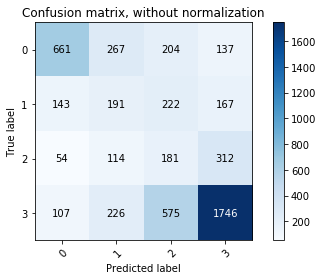

In [41]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_labels, test_predictions, classes=['0','1','2','3'],
                      title='Confusion matrix, without normalization')

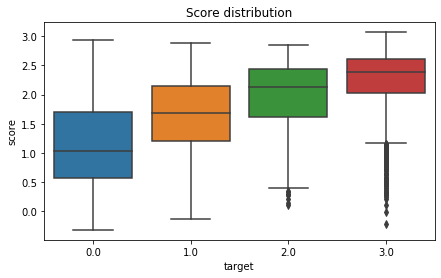

In [42]:
plot_score_dist(test_labels, y_pred)

In [43]:
test = pd.DataFrame({'installation_id': test_features.index.tolist(),
                      'accuracy_group': test_predictions})

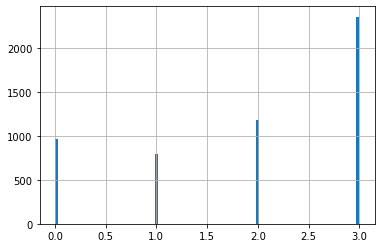

In [44]:
test['accuracy_group'].hist(bins=100)
pass

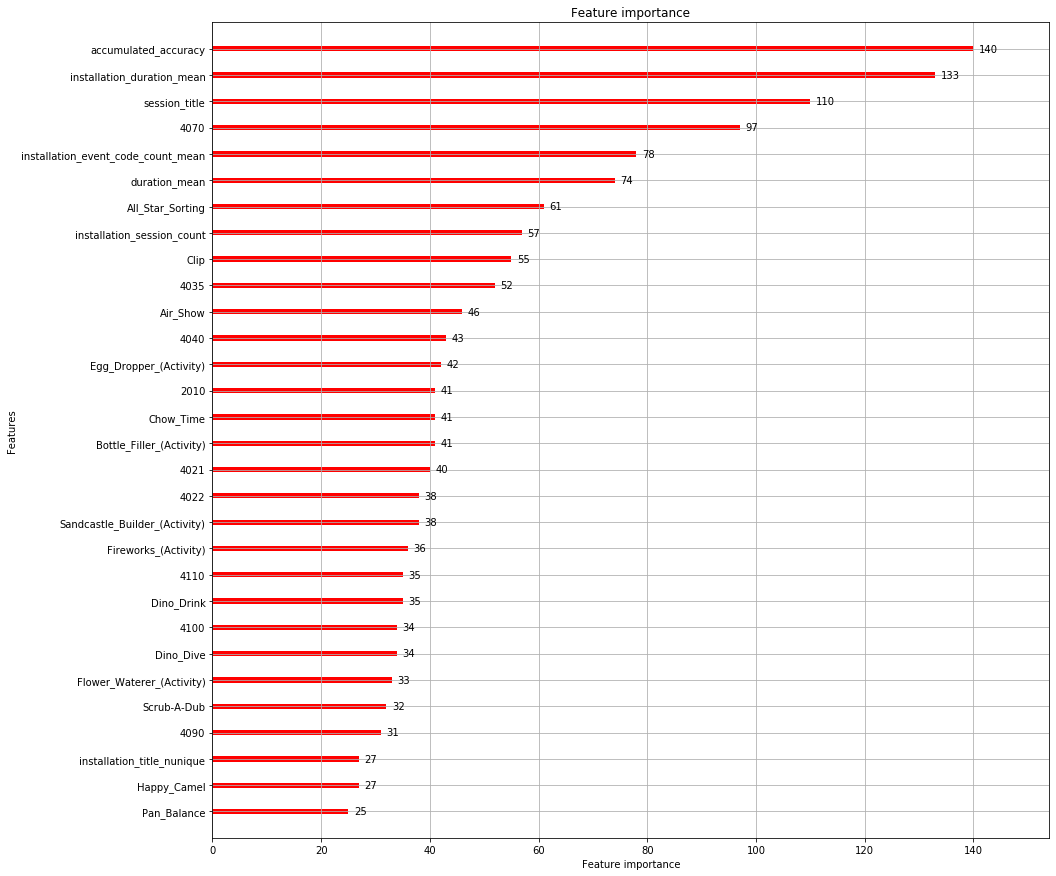

In [45]:
lgb.plot_importance(booster=model, figsize=(15,15), max_num_features=30, color='red')
pass